# Lab 05-3: Simple Deep Neural Network
## Exercise: Predicting MNIST Digits

### Prepare Mini-MNIST Dataset from Scikit-Learn
http://yann.lecun.com/exdb/mnist/

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

digits = load_digits()

# digits.data from sklearn contains 1797 images of 8x8 pixels
# Each image has a hand-written digit
digits_df = digits.images.reshape((len(digits.target), -1))
digits_tf = digits.target

# Splitting dataframe into train & test
X_train_org, X_test_org, y_train_num, y_test = train_test_split(digits_df, digits_tf, test_size= 0.20, random_state= 101)

# Digits data has range of [0,16], which often lead too big exponential values
# so make them normal distribution of [0,1] with the sklearn package, or you can just divide them by 16
sc = StandardScaler()
X_train = sc.fit_transform(X_train_org)
X_test = sc.transform(X_test_org)

n_classes = 10

# Transform Nx1 Y vector into Nx10 answer vector, so that we can perform one-to-all classification
y_train = np.zeros((y_train_num.shape[0],10))
for i in range(n_classes):
    y_train[:,i] = (y_train_num == i)

Define Utility Functions

In [ ]:
def sigmoid(x):
    # Numerically stable with large exponentials
    x = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return x

def softmax(x):
    # Numerically stable with large exponentials
    x = x - np.max(x, axis=-1, keepdims=True)
    x = np.exp(x)
    xs = np.sum(x, axis=-1, keepdims=True)
    return x / xs

(1797, 64)
(1437, 64)
(1437, 10)
[ 0.  0.  0.  9. 16.  6.  0.  0.  0.  0.  4. 15.  6. 15.  0.  0.  0.  0.
  8. 11.  9. 11.  0.  0.  0.  0.  8. 16. 14.  2.  0.  0.  0.  0. 11. 16.
 13.  0.  0.  0.  0.  6. 14.  2. 12.  9.  0.  0.  0.  5. 16. 11.  5. 13.
  4.  0.  0.  0.  3.  8. 13. 16.  9.  0.]


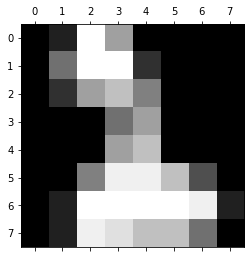

The number is 2


In [ ]:
print(digits_df.shape)
print(X_train.shape)
print(y_train.shape)
print(X_train_org[0])

idx = np.random.randint(X_train.shape[0])
dimage = X_train_org[idx].reshape((8,8))
plt.matshow(dimage)
plt.gray()
plt.show()
print('The number is', y_train_num[idx])


### Simple DNN for Digit Classification

Define Model Class (<b>From the previous exercise 05-2</b>)

In [ ]:
class myNeuralLayer:
    def __init__(self, n_out, n_in):
        self.wegt = np.zeros((n_out, n_in))
        self.bias = np.zeros((n_out))

    def forward(self, x):                      # (b, i)
        ### START CODE HERE ###

        x_lin = x @ self.wegt.T + self.bias            # Linear Prediction
        
        ### END CODE HERE ###
        return x_lin

    def backward(self, x, x_in):  # x = dJ/dz (b, c)
        ### START CODE HERE ###
        
        dw = x.T @ x_in / x.shape[0]               # Gradients for weights
        db = np.mean(x, axis=0)               # Gradients for biases
        wdJdz = x @ self.wegt            # Propagation for lower layer
        
        ### END CODE HERE ###
        return dw, db, wdJdz


Define Backpropagation of Activation Functions (<b>From the previous exercise 05-2</b>)

In [ ]:
def dJdz_sigmoid(wdJdz_upper, az):
    ### START CODE HERE ###

    dJdz = wdJdz_upper * az * (1 - az)            # backpropagation through activation function
    
    ### END CODE HERE ###
    return dJdz

def dJdz_softmax(y_hat, y):
    ### START CODE HERE ###
    
    dJdz = y_hat - y            # backpropagation through activation function
    
    ### END CODE HERE ###
    return dJdz

Define Training Functions<br>
<b>Fill `my_forward`, `my_backward`, `my_loss`, and `my_predict` with the previous exercise 05-2</b>

In [ ]:
def my_forward(l1, l2, l3, X_in):
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))                    # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                    # third stage forward

    ### END CODE HERE ###
    return a_1, a_2, a_3

def my_backward(l1, l2, l3, a_1, a_2, a_3, X_in, y_true):
    ### START CODE HERE ###

    dw_3, db_3, wdJdz_3 = l3.backward(dJdz_softmax(a_3, y_true), a_2)    # go through 3rd stage backward
    dw_2, db_2, wdJdz_2 = l2.backward(dJdz_sigmoid(wdJdz_3, a_2), a_1)    # go through 2nd stage backward
    dw_1, db_1, _       = l1.backward(dJdz_sigmoid(wdJdz_2, a_1), X_in)    # go through 1st stage backward

    ### END CODE HERE ###

    d_1 = [dw_1, db_1]
    d_2 = [dw_2, db_2]
    d_3 = [dw_3, db_3]
    
    return d_1, d_2, d_3

def my_loss(l1, l2, l3, X_in, y_true):
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))                    # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                    # third stage forward
    loss = -np.mean(y_true * np.log(a_3))                   # calculate loss

    ### END CODE HERE ###
    return loss
    
def my_predict(l1, l2, l3, X_in):
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))                    # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                   # third stage forward
    pred = np.argmax(a_3, axis=1)                   # make prediction

    ### END CODE HERE ###
    return pred

Create a NN model and check the matrix dimensions

In [ ]:
n_inputs  = 64
n_hidden1 = 80
n_hidden2 = 70
n_classes = 10

l1 = myNeuralLayer(n_hidden1, n_inputs)
l2 = myNeuralLayer(n_hidden2, n_hidden1)
l3 = myNeuralLayer(n_classes, n_hidden2)

print(X_train.shape, y_train.shape)
print(l1.wegt.shape, l1.bias.shape)
print(l2.wegt.shape, l2.bias.shape)
print(l3.wegt.shape, l3.bias.shape)

(1437, 64) (1437, 10)
(80, 64) (80,)
(70, 80) (70,)
(10, 70) (10,)


Weight Initialization

In [ ]:
# Weights are initialized to...
l1.wegt = np.random.randn(n_hidden1, n_inputs)
l2.wegt = np.random.randn(n_hidden2, n_hidden1)
l3.wegt = np.random.randn(n_classes, n_hidden2)

Training Simple Neural Network Model (3 layer model) (<b>Update weights</b>)

In [ ]:
# alpha: learning rate, lamda: regularization factor
alpha = 0.01
n_epochs = 5000
n_train = X_train.shape[0]

for epoch in range(n_epochs):
    ### START CODE HERE ###

    # Forward Path
    a_1, a_2, a_3 = my_forward(l1, l2, l3, X_train)   # forward path
    
    # Backward Path
    d_1, d_2, d_3 = my_backward(l1, l2, l3, a_1, a_2, a_3, X_train, y_train)   # backward path

    ### END CODE HERE ###

    dw_1, db_1 = d_1
    dw_2, db_2 = d_2
    dw_3, db_3 = d_3

    # Update weights and biases
    ### START CODE HERE ###
    
    l3.wegt = l3.wegt - alpha * dw_3 
    l3.bias = l3.bias - alpha * db_3 
    l2.wegt = l2.wegt - alpha * dw_2 
    l2.bias = l2.bias - alpha * db_2 
    l1.wegt = l1.wegt - alpha * dw_1 
    l1.bias = l1.bias - alpha * db_1 
    
    ### END CODE HERE ###

    # Print loss
    if ((epoch+1)%500==0):
        loss_J = my_loss(l1, l2, l3, X_train, y_train)
        print('Epoch: %4d,  loss: %10.8f' % (epoch+1, loss_J))

Epoch:  500,  loss: 2697.31858278
Epoch: 1000,  loss: 1633.55088151
Epoch: 1500,  loss: 1189.20337782
Epoch: 2000,  loss: 946.79635225
Epoch: 2500,  loss: 789.64193089
Epoch: 3000,  loss: 676.89429773
Epoch: 3500,  loss: 590.82524260
Epoch: 4000,  loss: 522.54101357
Epoch: 4500,  loss: 466.89546892
Epoch: 5000,  loss: 420.56697056


Evaluate Model Performance

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = my_predict(l1, l2, l3, X_test)

accuracy_score(y_pred, y_test)

0.8277777777777777

Neural Network from scikit-learn

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(80, 70, ), activation='logistic', solver='sgd', \
                    alpha=0.01, learning_rate_init=0.01, max_iter=1000)

# Training/Fitting the Model
mlp.fit(X_train, y_train_num)

# Making Predictions
s_pred = mlp.predict(X_test)
accuracy_score(s_pred, y_test)

0.9694444444444444

### Test Model with a random sample


<Figure size 432x288 with 0 Axes>

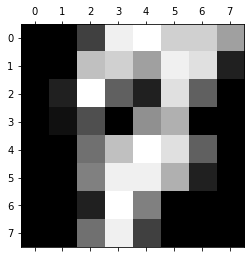

My prediction is 7
sk prediction is 7
Actual number is 7


In [ ]:
idx = np.random.randint(X_test.shape[0])
dimage = X_test_org[idx].reshape((8,8))
plt.gray()
plt.matshow(dimage)
plt.show()

X_input = np.expand_dims(X_test[idx], 0)

y_pred = my_predict(l1, l2, l3, X_input)

s_pred = mlp.predict(X_input)

print('My prediction is ' + str(y_pred[0]))
print('sk prediction is ' + str(s_pred[0]))
print('Actual number is ' + str(y_test[idx]))
